In [1]:
import os 

# Limit GPU consumption
DEVICE = '2'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
import jax.numpy as jnp
import numpy as np

import haiku as hk
import optax

import matplotlib.pyplot as plt

# Make matplotlib do grayscale stuff
# plt.rcParams['image.cmap'] = 'gray'

In [119]:
## Import TF temporarily for comparisons

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

def conv_cast(arr, cast_type=tf.float32):
    return tf.cast(tf.convert_to_tensor(arr), cast_type)

def periodic_padding_tf(image, padding=1):
    '''
    Create a periodic padding (wrap) around an image stack, to emulate periodic boundary conditions
    Adapted from https://github.com/tensorflow/tensorflow/issues/956
    
    If the image is 3-dimensional (like an image batch), padding occurs along the last two axes
    
    
    '''
    if len(image.shape)==2:
        upper_pad = image[-padding:,:]
        lower_pad = image[:padding,:]

        partial_image = tf.concat([upper_pad, image, lower_pad], axis=0)

        left_pad = partial_image[:,-padding:]
        right_pad = partial_image[:,:padding]

        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=1)
        
    elif len(image.shape)==3:
        upper_pad = image[:,-padding:,:]
        lower_pad = image[:,:padding,:]

        partial_image = tf.concat([upper_pad, image, lower_pad], axis=1)

        left_pad = partial_image[:,:,-padding:]
        right_pad = partial_image[:,:,:padding]

        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=2)
        
        
    else:
        assert True, "Input data shape not understood."
    
    return padded_image


def make_game_of_life_tf():
    '''
    Returns a simplified Tensorflow implementation of Conway's Game of Life
    '''
    
    neighborhood_radius = 3
    pad_size = 1

    neighbor_filt = np.ones((neighborhood_radius,neighborhood_radius))
    neighbor_filt[1,1] = 0
    middle_filt = np.zeros((neighborhood_radius,neighborhood_radius))
    middle_filt[1,1] = 1
    all_filters = np.dstack((middle_filt, neighbor_filt, neighbor_filt, neighbor_filt, neighbor_filt))
    all_biases = np.array([0,  -1, -2, -3, -4]) 
    total_filters = len(all_biases)
    kernel = conv_cast(all_filters)[:,:,tf.newaxis,:]
    biases = conv_cast(all_biases)
    
    wh1_arr = np.array([
    [0, 0, 4/3, -8/3, -1/3],
    [3/2, 5/4, -5, -1/4, -1/4]
    ]).T
    bh1_arr = np.array([-1/3,-7/4]).T
    wh1 = conv_cast(wh1_arr)
    bh1 = conv_cast(bh1_arr)
    
    def my_ca(image_stack):
        '''
        Automatically generated function created by make_ca()
        Input array must already be a tensor when fed to the function
        '''
        input_padded = periodic_padding_tf(image_stack, pad_size)[...,tf.newaxis]

        print(f"shape of image stack: {image_stack.shape},\n\
                and input_padded: {input_padded.shape}")
        
        conv_image = tf.nn.conv2d(input_padded, kernel, strides=[1,1,1,1], padding='VALID')

        print(f"shape of kernel: {kernel.shape}, conv_image: {conv_image.shape}")
        
        activation_image = tf.nn.relu(conv_image + biases)

        activated_flat = tf.reshape(activation_image, [-1, total_filters])
        
        h1 = tf.nn.relu(tf.matmul(activated_flat, wh1) + bh1)

        scores = tf.reduce_sum(h1, axis=-1)
        next_states = tf.reshape(scores, [*activation_image.shape[:3],1])
        
        return tf.squeeze(next_states)

    return my_ca


1 Physical GPUs, 1 Logical GPUs


First order of business is to figure out how data works here

In [175]:
### A cell to generate some data

n_states = 2  # number of states for each cell
train_size = 100  # number of samples
wspan, hspan = 10, 10  # height and width of grid

X_train = np.random.choice(list(range(n_states)), 
                 size=(train_size, wspan, hspan)).astype(float)
X_train.shape, X_train[0].shape, X_train.dtype
# Y_train.shape

# Let's do the game of life 

((100, 10, 10), (10, 10), dtype('float64'))

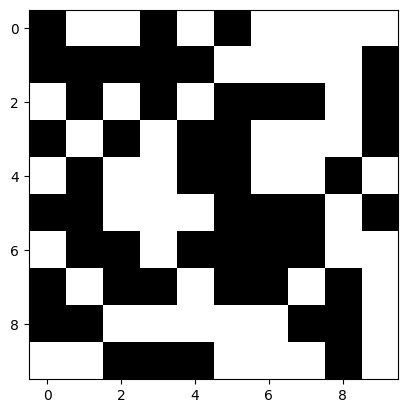

In [216]:
plt.imshow(X_train[50], cmap='gray')
# plt.imshow(X_train[50])
plt.show()

In [177]:
## Somewhat semi-randomly, I now wonder if there can be a diffusion
# inspired analogy here, where we take a state and apply the rule
# for some number of steps, randomly, which generates our "noised" input
# Or rather, this will be what the CA tries to get to. 
# Then the network can be designed such that the output is some conception
# of the rule, which then manually is applied to get the CA at that state.

# The loss would have to be (if we maintain the analogy to diffusion),
# something between what the model predicts as output (i.e. the 
# predicted CA rule) and the actual rule. 

# Get a random seed from JAX
rng = jax.random.PRNGKey(22)


In [178]:
def periodic_padding(image, padding=1):
    '''
    Create a periodic padding (wrap) around an image stack, to emulate periodic boundary conditions
    Adapted from https://github.com/tensorflow/tensorflow/issues/956
    
    If the image is 3-dimensional (like an image batch), padding occurs along the last two axes
    
    
    '''
    if len(image.shape)==2:
        upper_pad = image[-padding:,:]
        lower_pad = image[:padding,:]

        partial_image = tf.concat([upper_pad, image, lower_pad], axis=0)

        left_pad = partial_image[:,-padding:]
        right_pad = partial_image[:,:padding]

        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=1)
        
    elif len(image.shape)==3:
        upper_pad = image[:,-padding:,:]
        lower_pad = image[:,:padding,:]

        partial_image = tf.concat([upper_pad, image, lower_pad], axis=1)

        left_pad = partial_image[:,:,-padding:]
        right_pad = partial_image[:,:,:padding]

        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=2)
        
        
    else:
        assert True, "Input data shape not understood."
    
    return padded_image

(10, 10) (100, 12, 12)


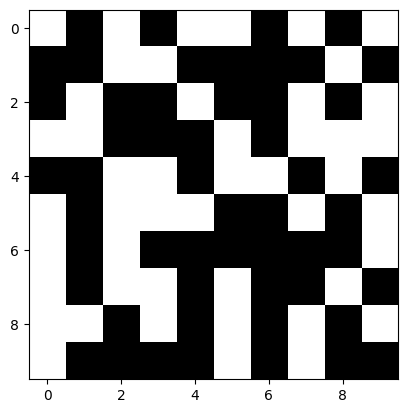

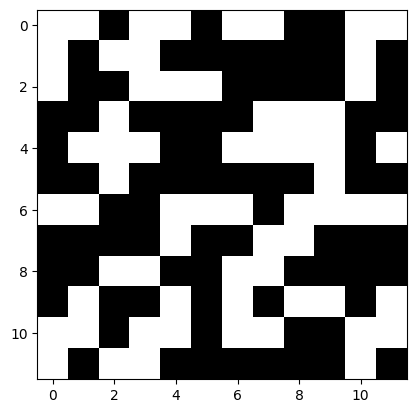

In [217]:
def periodic_padding(image, padding=1):
    """Do padding (wrap around) for an image stack.
        Similarly to Gilpin's work, pad along the last two
        axes for 3-dimensional, batched images
    """
    
    if len(image.shape) == 2:
        upper_pad = image[-padding:, :]
        lower_pad = image[:padding, :]
    
        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=0)
    
        left_pad = partial_image[:, -padding:]
        right_pad = partial_image[:, :padding]
    
        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=1)

    if len(image.shape) == 3:
        upper_pad = image[:, -padding:, :]
        lower_pad = image[:, :padding, :]
    
        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=1)
    
        left_pad = partial_image[:, :, -padding:]
        right_pad = partial_image[:, :, :padding]
    
        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=2)

    else:
        assert True, "Input data shape not understood."
        
    return padded_image

out = periodic_padding(X_train)
print(X_train[0].shape, out.shape)

plt.imshow(X_train[0], cmap='gray'), 
plt.show() 
plt.imshow(out[1], cmap='gray')

In [218]:
def periodic_padding(image, padding=1):
    """Do padding (wrap around) for an image stack.
        Similarly to Gilpin's work, pad along the last two
        axes for 3-dimensional, batched images
    """
    
    if len(image.shape) == 2:
        upper_pad = image[-padding:, :]
        lower_pad = image[:padding, :]
    
        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=0)
    
        left_pad = partial_image[:, -padding:]
        right_pad = partial_image[:, :padding]
    
        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=1)

    if len(image.shape) == 3:
        upper_pad = image[:, -padding:, :]
        lower_pad = image[:, :padding, :]
    
        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=1)
    
        left_pad = partial_image[:, :, -padding:]
        right_pad = partial_image[:, :, :padding]
    
        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=2)

    else:
        assert True, "Input data shape not understood."
        
    return padded_image

def make_game_of_life():

    pad_size = 1
    center_pixel_filter = np.zeros((3, 3))
    center_pixel_filter[1, 1] = 1
    outer_pixel_filter = np.ones((3, 3))
    outer_pixel_filter[1, 1] = 0

    all_filters = np.dstack(
        (center_pixel_filter, outer_pixel_filter, outer_pixel_filter,
         outer_pixel_filter, outer_pixel_filter)
    )
    all_biases = np.array([0, -1, -2, -3, -4])
    total_filters = len(all_biases)
    kernel = all_filters[:, :, np.newaxis, :]
    biases = all_biases

    wh1 = np.array([
        [0, 0, 4/3, -8/3, -1/3],
        [3/2, 5/4, -5, -1/4, -1/4]
    ]).T
    bh1 = np.array([-1/3,-7/4]).T

    def make_ca(image_stack: jax.Array) -> jax.Array:

        input_padded = periodic_padding(image_stack, pad_size)[..., np.newaxis].astype(float)

        print(f"shape of image stack: {image_stack.shape},\n\
                and input_padded: {input_padded.shape}")
        print(f"shape of kernel: {kernel.shape}")
        print(f"type of kernel: {kernel.dtype}, and type of input_padded: {input_padded.dtype}")
        
        # Apply the convolutions
        conv_image = jax.lax.conv_general_dilated(input_padded,
                                  kernel,
                                  window_strides=(1, 1),
                                  padding='VALID',
                                  dimension_numbers=('NHWC', 'HWIO', 'NHWC'),
                                 )

        print(f"Shape of conv_image: {conv_image.shape}")
        
        activation_image = jax.nn.relu(conv_image + biases)

        activated_flat = np.reshape(activation_image, [-1, total_filters])
        h1 = jax.nn.relu(np.matmul(activated_flat, wh1) + bh1)

        scores = jnp.sum(h1, axis=-1)
        next_states = np.reshape(scores, [*activation_image.shape[:3], 1])

        return np.squeeze(next_states)
        
    return make_ca


In [219]:
gol = make_game_of_life()
Y_train = gol(X_train)

gol_tf = make_game_of_life_tf()
Y_train_tf = gol_tf(tf.convert_to_tensor(X_train, tf.float32))

shape of image stack: (100, 10, 10),
                and input_padded: (100, 12, 12, 1)
shape of kernel: (3, 3, 1, 5)
type of kernel: float64, and type of input_padded: float64
Shape of conv_image: (100, 10, 10, 5)
shape of image stack: (100, 10, 10),
                and input_padded: (100, 12, 12, 1)
shape of kernel: (3, 3, 1, 5), conv_image: (100, 10, 10, 5)


In [220]:
Y_train.shape

(100, 10, 10)

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


Text(0.5, 1.0, 'TF Output')

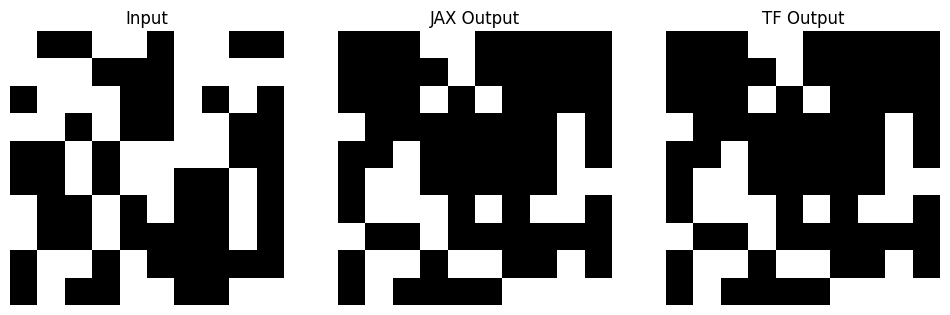

In [293]:
i = 9

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X_train[i], cmap='gray')
plt.axis('off')
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(Y_train[i], cmap='gray')
print(type(Y_train[i]))
plt.axis('off')
plt.title("JAX Output")

plt.subplot(1,3,3)
plt.imshow(Y_train_tf[i], cmap='gray')
print(type(Y_train_tf[i]))
plt.axis('off')
plt.title("TF Output")


In [184]:
X_train.shape, Y_train.shape, X_train.dtype, Y_train.dtype

((100, 10, 10), (100, 10, 10), dtype('float64'), dtype('float32'))

In [234]:
def network_fn(data: jax.Array, layer_dims):
    """For now we assume the `data` object is a 3-dimensional
        array
    """
    num_classes = 2
    conv_pad = 'same'
    network = hk.Sequential([
            hk.Conv2D(layer_dims[0], kernel_shape=(3,3), padding=conv_pad),
            hk.Reshape(output_shape=(-1, layer_dims[0]))
        ] + \
        [
            hk.Linear(layer_dims[i]) for i in range(1, len(layer_dims))
        ] + \
        [
            hk.Linear(num_classes)
        ]
    )
    print(network)
    return network(data)

def logit_to_pred(logits, shape=None):
    """Transform logits to images"""
    labels = jnp.argmax(jax.nn.softmax(logits), axis=-1)
    if shape:
        out = jnp.reshape(labels, shape)
    return out.astype(np.float64)

In [235]:
## Training loop?

from typing import NamedTuple

class Batch(NamedTuple):
    X: np.ndarray  # [B, H, W, 1]
    Y: np.ndarray  # [B, H, W, 1]

def loss_fn(params: hk.Params, batch: Batch):
    X_train = batch.X
    transformed_fn.apply(params, X_train,
    optax.softmax_cross_entropy(

SyntaxError: incomplete input (378415535.py, line 12)

In [236]:
# Transform the network
transformed = hk.without_apply_rng(hk.transform(network_fn))

# Get appropriately-shaped data and pass it in
X_train_transformed = X_train[..., np.newaxis]

# Get initial params and apply the network
init_params = transformed.init(rng, X_train_transformed, [10,10,10])
out = transformed.apply(init_params, X_train_transformed, [10,10,10])

print(X_train_transformed.shape, out.shape)

Sequential(
    layers=[Conv2D(output_channels=10, kernel_shape=(3, 3), padding='same'),
            Reshape(output_shape=(-1, 10)),
            Linear(output_size=10),
            Linear(output_size=10),
            Linear(output_size=2)],
)
Sequential(
    layers=[Conv2D(output_channels=10, kernel_shape=(3, 3), padding='same'),
            Reshape(output_shape=(-1, 10)),
            Linear(output_size=10),
            Linear(output_size=10),
            Linear(output_size=2)],
)
(100, 10, 10, 1) (100, 100, 2)


In [237]:
print(out.shape)
# plt.imshow(out[0], cmap='gray')
# print(out[1:])

preds = logit_to_pred(out, shape=(-1, wspan, hspan))
preds.shape

(100, 100, 2)


/tmp/ipykernel_189/3703276860.py:26: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return out.astype(np.float64)


(100, 10, 10)

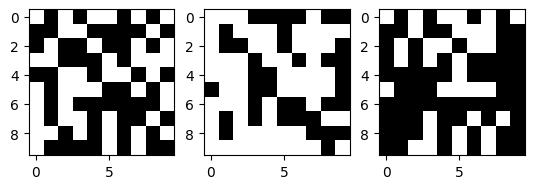

In [238]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)

ax0.imshow(X_train[0], cmap='gray')
ax1.imshow(preds[0], cmap='gray')
ax2.imshow(Y_train[0], cmap='gray')

In [252]:
print(out.shape, Y_train.shape)
loss = optax.softmax_cross_entropy(out, Y_train)

(100, 100, 2) (100, 10, 10)


In [265]:
Y_train_onehot.shape

TensorShape([100, 10, 10, 2])

In [261]:
Y_train_onehot = tf.squeeze(tf.one_hot(tf.cast(Y_train, tf.int32), num_classes))
print(Y_train_onehot.shape
num_classes = 2
loss_f = lambda x, y : tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)), 
                                                                  tf.reshape(y, shape=(-1, num_classes)), 
                                                                  from_logits=True)

(100, 10, 10, 2)


In [282]:
# loss_f(out, Y_train_onehot)
lossf1 = loss_f(out, Y_train_onehot)
lossf1

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([ 0.17954601,  0.11256593,  0.29058778, ..., -0.30501208,
        0.29086876,  0.07855719], dtype=float32)>

In [283]:
print(preds.shape, Y_train.shape)
print(tf.reshape(preds, shape=(-1, num_classes)).shape)

lossf2 = loss_f(preds, Y_train)
lossf2

(100, 10, 10) (100, 10, 10)
(5000, 2)


<tf.Tensor: shape=(5000,), dtype=float32, numpy=
array([1.6265235 , 0.31326175, 0.        , ..., 1.3132617 , 1.3862944 ,
       1.6265235 ], dtype=float32)>

In [276]:
preds_reshaped = np.reshape(preds, newshape=(-1, num_classes))
preds_reshaped_tf = tf.reshape(preds, shape=(-1, num_classes))

Y_train_reshaped = np.reshape(Y_train, newshape=(-1, num_classes))
lossf = loss_f(preds_reshaped, Y_train_reshaped)

In [288]:
out.shape, preds.shape, Y_train.shape, Y_train_onehot.shape

((100, 100, 2), (100, 10, 10), (100, 10, 10), TensorShape([100, 10, 10, 2]))

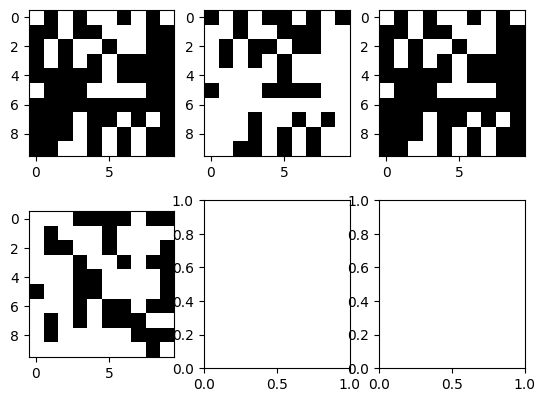

In [298]:
fig, ((ax0, ax1, ax2), (ax10, ax11, ax12)) = plt.subplots(2, 3)
ax0.imshow(Y_train[0], cmap='gray')
ax1.imshow(Y_train_onehot[0, :, :, 0], cmap='gray')
ax2.imshow(Y_train_onehot[0, :, :, 1], cmap='gray')

ax10.imshow(preds[0], cmap='gray')
ax11.imshow(out